In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


In [2]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8) # set default figure size, 12in by 10in
sns.set_style("whitegrid")

This week, we will be covering anomaly detection which is widely used in fraud detection (e.g. ‘has this credit card been stolen?’). Given a large number of data points, we may sometimes want to figure out which ones vary significantly from the average. For example, in manufacturing, we may want to detect defects or anomalies. We show how a dataset can be modeled using a Gaussian distribution, and how the model can be used for anomaly detection.

# Video W9 01: Problem Motivation (Anomaly Detection)

[YouTube Video Link](https://www.youtube.com/watch?v=hhI-PdMO1sk&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=89)

Imagine you are a a manufacturer and are performing quality control on your manufacturing process. You might
gather data with features like:

- $x_0 = $ heat generated
- $x_1 = $ vibration intensity.

We might have data that looks like this:

Text(4.1, 1.7, 'anomaly')

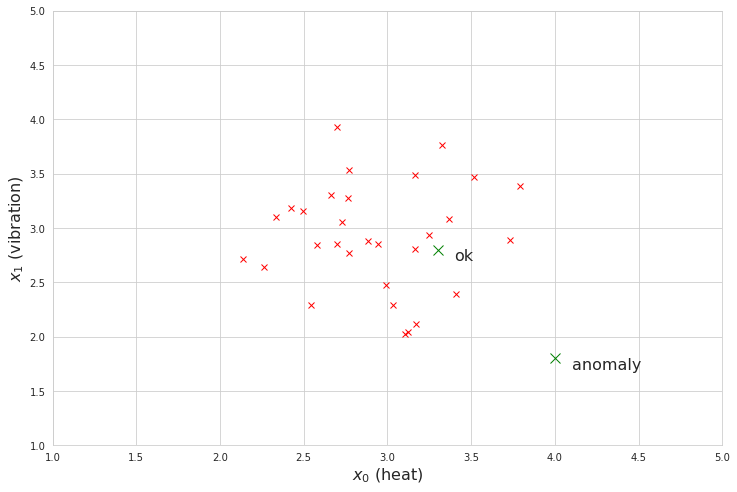

In [3]:
# just make a random dataset example where both features are distributed in a normal distribution
m = 30 # number of samples to generate
mu = 0.0
sigma = 0.5

np.random.seed(42)
X = np.random.normal(mu, sigma, (m, 2)) + 3.0

# plot the ok data
plt.plot(X[:,0], X[:,1], 'rx');
plt.axis([1, 5, 1, 5]);
plt.xlabel('$x_0$ (heat)', fontsize=16);
plt.ylabel('$x_1$ (vibration)', fontsize=16);

# new item x_test
x_test1 = np.array([3.3, 2.8])
plt.plot(x_test1[0], x_test1[1], 'gx', markersize=10)
plt.text(x_test1[0]+0.1, x_test1[1]-0.1, 'ok', fontsize=16)

x_test2 = np.array([4.0, 1.8])
plt.plot(x_test2[0], x_test2[1], 'gx', markersize=10)
plt.text(x_test2[0]+0.1, x_test2[1]-0.1, 'anomaly', fontsize=16)


More formaly, in anomaly detection we are given some dataset: $\{ x^{(1)}, x^{(2)}, \cdots, x^{(m)} \}$

We assume that the given dataset is normal, that it represents usual samples of the dataset.

We want an algorithm that tells us if a new sample $x_{test}$ is "anomalous", where this will mean that
it looks out of the expected range or pattern for the dataset given the nonanomalous data.

In one sense the training set is unlabeled, though you can also think of it as a set of data all labeled
as ok.  

We want to build a model $p(x)$, which is the probability of $x$, where $x$ is the features of the dataset.

\begin{equation}
\begin{cases}
p(x_{test}) < \epsilon \to \text{flag as anomalous}\\
p(x_{test}) \ge \epsilon \to \text{ok}
\end{cases}
\end{equation}

The model $p(x)$ needs to estimate the "density" of the data, so that points in the dense part of the
distribution are assigned a high probability density, and those that are far from other examples are
assigned a low probability.

## Anomaly detection example

- Fraud detection:
  - $x^{(i)} = $ features of user $i$'s activities (how often log in, typing speed, etc.)
  - Model $p(x)$ from data.
  - Identify unusual users by checking which have $p(x) < \epsilon$
  
- Manufacturing
- Monitoring computers in a data center.
  - $x^{(i)} = $ features of machine $i$
  - memory use, number of disk accesses/sec, CPU load, CPU load / network traffic
  


# Video W9 02: Gaussian Distribution

[YouTube Video Link](https://www.youtube.com/watch?v=2yosK5CJZmo&index=90&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW)

## Gaussian (Normal) distribution

A review of the gaussian distribution.  Say $x \in \mathbb{R}$ If $x$ is a random variable distributed according
to a Gaussian distribution, with a mean $\mu$ and variance $\sigma^2$ (or equivalently standard deviation $\sigma$,
then the continuous probability density function of the random variable is given by the formula:

\begin{equation}
n(x; \mu, \sigma) = \frac{1}{ \sqrt{2 \pi \sigma} } e^{- \frac{1}{2 \sigma^2} (x - \mu)^2 }
\end{equation}


We normally don't have to know the formula to work with a gaussian distribution.  In Python, it is
best to use the `scipy.stats` classes that are defined to work with standard probability distributions.
The `scipy.stats.norm` class defines the normal or gaussian distribution.

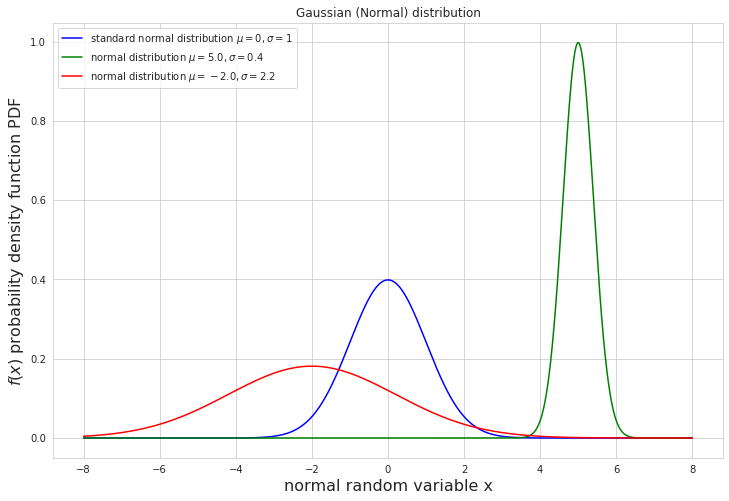

In [4]:
from scipy.stats import norm

# the default when creating a normal distribution from scipy.stats is to create a standard
# normal distribution with mu=0 and sigma=1, so we don't really have to pass in the
# metaparameters here if we want a standard normal distribution, we are given one by default
n_standard = norm()

# create some other normal distributions
mu_1 = 5.0
sigma_1 = 0.4
n_1 = norm(mu_1, sigma_1)

mu_2 = -2.0
sigma_2 = 2.2
n_2 = norm(mu_2, sigma_2)


# plot the standard normal distribution and the other ones for comparison
x = np.linspace(-8.0, 8.0, 1000)
plt.plot(x, n_standard.pdf(x), 'b-', label='standard normal distribution $\mu=0, \sigma=1$')
plt.plot(x, n_1.pdf(x), 'g-', label='normal distribution $\mu=%0.1f, \sigma=%0.1f$' % (mu_1, sigma_1))
plt.plot(x, n_2.pdf(x), 'r-', label='normal distribution $\mu=%0.1f, \sigma=%0.1f$' % (mu_2, sigma_2))
plt.xlabel('normal random variable x', fontsize=16);
plt.ylabel('$f(x)$ probability density function PDF', fontsize=16);
plt.legend();
plt.title('Gaussian (Normal) distribution');

Notice that we use the `.pdf()` function of the `scipy.stats.norm` object to plot the probability density function
of the normal curves.   A standard normal distribution has a mean of 0 and a standard deviation/variance of 1.
Notices that for other normal distributions, the `norm` object takes the mean $\mu$ and the standard deviation
$\sigma$ as meta parameters that define the distributions.  When the standard deviation is small, the
distribution will be skinny and tall.  When the standard deviation is large, the density will be more flat
and spread out.  But in all cases, the are probability density functions, so the area under the curves
all add up to 1.

In [5]:
from scipy.integrate import quad as integrate

integrate(n_standard.pdf, -np.infty, np.infty)

(0.9999999999999998, 1.0178191320905743e-08)

As an aside, we can also draw or generate random samples from a normal distribution. I actually did that above
to create the example data, using the `np.random.normal()` function.  You can also use `scipy.stats.norm`
function to draw a random sample from a normal distribution, using the `.rvs()` function, like this:

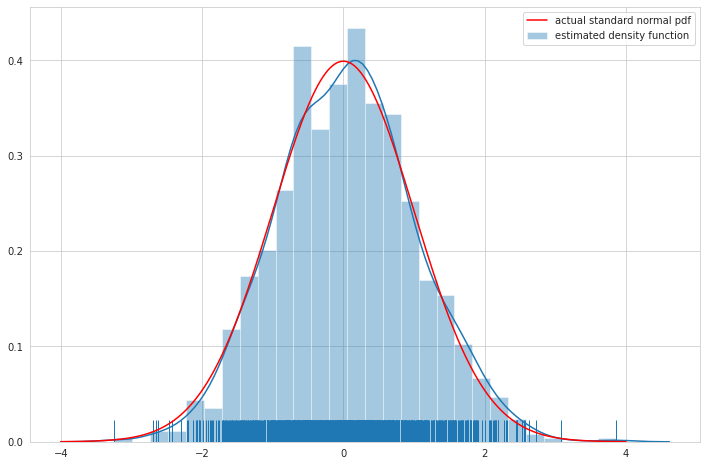

In [6]:
# draw random samples
NUM_SAMPLES = 1000
samples = n_standard.rvs(NUM_SAMPLES)

# visualize the resulting density of the random samples, using seaborn built in scatter plotting and density
# visualization capabilities
sns.distplot(samples, hist=True, rug=True, label='estimated density function');

# put the true pdf density function onto the estimated density plot
x = np.linspace(-4.0, 4.0, 1000)
plt.plot(x, n_standard.pdf(x), 'r-', label='actual standard normal pdf')

plt.legend();

## Parameter Estimation ##

The parameter estimation problem is basically, given a set of data that you suspect may be distributed according to a
Gaussian distribution, how do you determine the values of the mean $\mu$ and the standard deviation $\sigma$ that best
fit or explain the data you have been given.  We can use a simple maximum likelihood estimate to determine which values
for the $\mu, \sigma$ parameters fit the data.  To estimate $\mu$, simply calculate the mean of the data points
you have been given:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x^{(i)}
$$

Likewise, to estimate the variance $\sigma^2$, sum up the squares of each data point subtracted from your estimated
mean value:

$$
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x^{(i)} - \mu)^2
$$

Just to show that this approximation works, and to generate a set of data and figure similar to the one from our
companion video, lets create a set of 20 points drawn from a normal distribution with a mean of 1.5 and
a standard deviation of 0.75 using python:

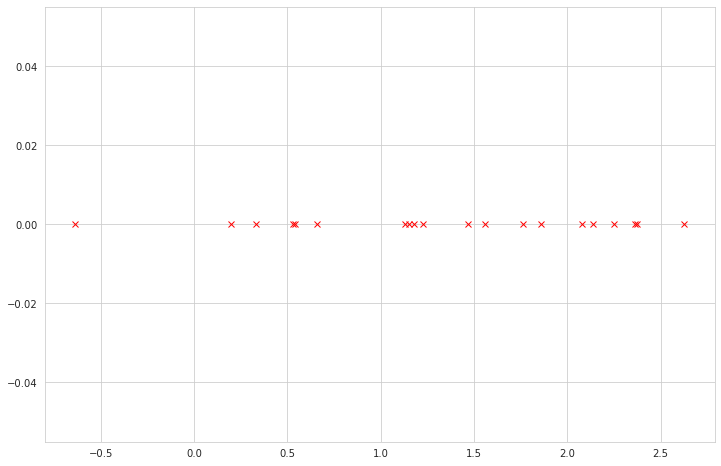

In [7]:
m = 20 # number of data points
mu_actual = 1.5 # the actual mean we will use to generate some example data points
sigma_actual = 0.75 # the actual standard deviation we will use to generate random data points

x = np.random.normal(loc=mu_actual, scale=sigma_actual, size = (m,))
plt.plot(x, np.zeros( (m,)), 'rx');

Remember that the actual mean and standard deviation we used for the points are 1.5 and 0.75 respectively.  We can get
mean likelihood estimates of the values for our randomly generated data like this:

In [8]:
mu_estimate = np.sum(x) / m
variance_estimate = np.sum( (x - mu_estimate)**2.0 ) / m
sigma_estimate = np.sqrt(variance_estimate)
print(mu_estimate, sigma_estimate, variance_estimate)

1.3382921172106135 0.8480846198163837 0.7192475223691002


In [9]:
# the .mean(), .std() and .var() functions of numpy arrays calculate the same thing 
print(x.mean(), x.std(), x.var())

1.3382921172106135 0.8480846198163837 0.7192475223691002


# Video W9 03: Anomaly Detection Algorithm

[YouTube Video Link](https://www.youtube.com/watch?v=egIWLtZjHoo&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=91)

## Density Estimation ##

One way to estimate the probability of a given observation being an anomaly or not is to make an independence assumption on
each of the $n$ features, and calculate the probability of getting each feature given our observed data.  To do this, we
use the previous method and assume that each of our features is normally distributed, and use a maximum likelihood estimate
to determine the mean and variance parameters for each of our features independently.  Given these estimations, we can use them
to calculate the probability of each observed feature, and multiplying all of these probabilities together (which works
because of the assumption of independence) gives us an overall estimate of the probability of seeing the new observation.

The final probability (or density) estimate can be stated compactly using the product formula

$$
\prod_{j=1}^n p(x_j; \mu_j, \sigma_j^2) = p(x_1; \mu_1, \sigma_1^2) \times p(x_2; \mu_2, \sigma_2^2) \times \ldots \times p(x_n; \mu_n, \sigma_n^2)
$$

Where for each of our $n$ features, we have determined the maximum likelihood $\mu_j, \sigma_j^2$ mean and variance
parameters.  The $\prod$ symbol simply means we are multiplying each of the $n$ probabilities together.

## Anomaly Detection Algorithm ##

Putting these previous concepts together, we can build an anomaly detection system using the following algorithm:

1. Choose features $x_i$ that you think might be indicative of anomalous examples.
2. Fit parameters $\mu_1, \ldots, \mu_n, \sigma_1^2, \ldots, \sigma_n^2$
$$
\mu_j = \frac{1}{m} \sum_{i=1}^{m} x_j^{(i)} \\
\sigma_j^2 = \frac{1}{m} \sum_{i=1}^{m} (x_j^{(i)} - \mu_j)^2 
$$
3. Given a new example $x$, compute $p(x)$:
$$
p(x) = \prod_{j=1}^n p(x_j; \mu_j, \sigma_j^2) = \prod_{j=1}^{n} \frac{1}{\sqrt{2 \pi} \sigma_j} \textrm{exp}(- \frac{(x_j - \mu_j)^2}{2 \sigma_j^2})
$$

And finally, we will determine a new observation is an anomaly if the probability is below some threshold, 
e.g. if $p(x) < \epsilon$.

Lets give an example in Python similar to the one shown in our video.  Lets again generate a set of data, but with
2 dimensions or features in this case.  As shown in the video, the mean and standard deviation we will use for our two
features will be:
$$
\mu_1 = 5, \sigma_1 = 2\\
\mu_2 = 3, \sigma_2 = 1
$$

Here we will show vectorized versions of computing the maximum likelihood estimates and probabilities:

In [10]:
m, n = 20, 2 # number of example data points ; number of features/dimensions
mu_actual = np.array([5.0, 3.0])
sigma_actual = np.array([2.0, 1.0])

# we will generate a mxn array of values with mean 0 and std 1.0
x = np.random.normal(loc=0.0, scale=1.0, size=(m, n))

# and we will scale each dimension to have the desired mean/std.
x[:,0] = (x[:,0] * sigma_actual[0]) + mu_actual[0]
x[:,1] = (x[:,1] * sigma_actual[1]) + mu_actual[1]

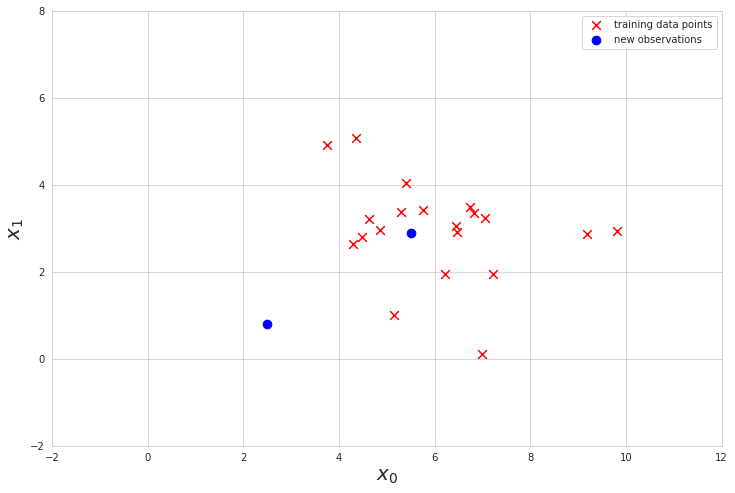

In [11]:
# display our randomly generated set of 20 data points in
# our 2 dimensional feature space
#plt.plot(x[:,0], x[:,1], 'rx', markersize=10, markeredgewidth=3, label='training data points')
plt.scatter(x[:,0], x[:,1], c='r', marker='x', s=75, label='training data points')
plt.xlabel('$x_0$', fontsize=20)
plt.ylabel('$x_1$', fontsize=20)
plt.axis([-2, 12, -2, 8])

# display location of 2 new observations we will use to demonstrate
# calculating the density or probability estimate
x_new = np.array([[5.5, 2.9],
                  [2.5, 0.8]])
#plt.plot(x_new[:,0], x_new[:,1], 'bo', markersize=10, markeredgewidth=3, label='new observations')
plt.scatter(x_new[:,0], x_new[:,1], c='b', marker='o', s=75, label='new observations')
plt.legend()

In [12]:
# define a function that compute the probability/density of an observation
def probability_density_function(x, mu, sigma):
    """Calculate the probability of the given observation x for a normal distribution with mean mu and
    standard deviation sigma.  These are known as computing the probability density function, or pdf.
    This is equivalent to the scipy libraries stats.norm.pdf() function.
    """
    return (1.0 / (np.sqrt(2.0 * np.pi) * sigma) ) * np.exp(- (x - mu)**2.0 / (2.0 * sigma**2.0) )

In [13]:
# calculate the maximum likelihood mean and variance for each dimension
print( "The maximum likelihood mean and variance for our 2 dimensions:" )
print( np.mean(x, axis=0) )
print( np.std(x, axis=0) )
mu_estimate = np.mean(x, axis=0)
sigma_estimate = np.std(x, axis=0)

# calculate the density or probability estimate for the new observations
# first an example of the probability calculation for the point 0, for dimension 0 and 1
print( "" )
print( "A new observation that is not analomous:", x_new[0,:] )
p_0 = probability_density_function(x_new[0, 0], mu_estimate[0], sigma_estimate[0])
print( "Probability for dimension 0:", p_0 )
p_1 = probability_density_function(x_new[0, 1], mu_estimate[1], sigma_estimate[1])
print( "Probability for dimension 1:", p_1 )
print( "Product of independent probabilities:", p_0 * p_1 )

# now the same calculation for our anamolous point 1
print( "" )
print( "A new observation that IS analomous:", x_new[1,:] )
p_0 = probability_density_function(x_new[1, 0], mu_estimate[0], sigma_estimate[0])
print( "Probability for dimension 0:", p_0 )
p_1 = probability_density_function(x_new[1, 1], mu_estimate[1], sigma_estimate[1])
print( "Probability for dimension 1:", p_1 )
print( "Product of independent probabilities:", p_0 * p_1 )


The maximum likelihood mean and variance for our 2 dimensions:
[6.04844122 2.96691212]
[1.54294066 1.10933966]

A new observation that is not analomous: [5.5 2.9]
Probability for dimension 0: 0.2427309421015668
Probability for dimension 1: 0.35896781649658716
Product of independent probabilities: 0.08713259628235895

A new observation that IS analomous: [2.5 0.8]
Probability for dimension 0: 0.018367945262696094
Probability for dimension 1: 0.05337234663482837
Product of independent probabilities: 0.0009803403415301697


In [14]:
# we can get the exact same results using the pdf function from scipy, which we should normally do rather
# than implementing the function by hand as I have done above
import scipy.stats
print("")
print("A new observation that is not analomous:", x_new[0,:])
p_0 = scipy.stats.norm.pdf(x_new[0, 0], loc=mu_estimate[0], scale=sigma_estimate[0])
print("Probability for dimension 0:", p_0)
p_1 = scipy.stats.norm.pdf(x_new[0, 1], loc=mu_estimate[1], scale=sigma_estimate[1])
print("Probability for dimension 1:", p_1)
print("Product of independent probabilities:", p_0 * p_1)

# now the same calculation for our anamolous point 1
print("")
print("A new observation that IS analomous:", x_new[1,:])
p_0 = scipy.stats.norm.pdf(x_new[1, 0], loc=mu_estimate[0], scale=sigma_estimate[0])
print("Probability for dimension 0:", p_0)
p_1 = scipy.stats.norm.pdf(x_new[1, 1], loc=mu_estimate[1], scale=sigma_estimate[1])
print("Probability for dimension 1:", p_1)
print("Product of independent probabilities:", p_0 * p_1)



A new observation that is not analomous: [5.5 2.9]
Probability for dimension 0: 0.24273094210156682
Probability for dimension 1: 0.35896781649658716
Product of independent probabilities: 0.08713259628235896

A new observation that IS analomous: [2.5 0.8]
Probability for dimension 0: 0.018367945262696087
Probability for dimension 1: 0.05337234663482838
Product of independent probabilities: 0.0009803403415301693


In [15]:
# or to vectorize the above
print("probabilities of all points for each dimension:")
p = scipy.stats.norm.pdf(x_new, loc=mu_estimate, scale=sigma_estimate)
print(p)

print("")
print("The computed product of the probabilites for our points:")
p = np.prod(p, axis=1)
print(p)

probabilities of all points for each dimension:
[[0.24273094 0.35896782]
 [0.01836795 0.05337235]]

The computed product of the probabilites for our points:
[0.0871326  0.00098034]


In [16]:
# and finally, we can select an epsilon threshold, and determine which points are anomalous and which not
# using the given threshold
epsilon = 0.005
print(p < epsilon)

[False  True]


The above cells showed how we can compute the anomaly detection algoritm.  Lets visualize what an epsilon value of 0.005 means
for our given set of 20 data points.  Here we will plot what is essentially the decision boundary for our given set of
data, above which the threshold will determine points are "anamolous"

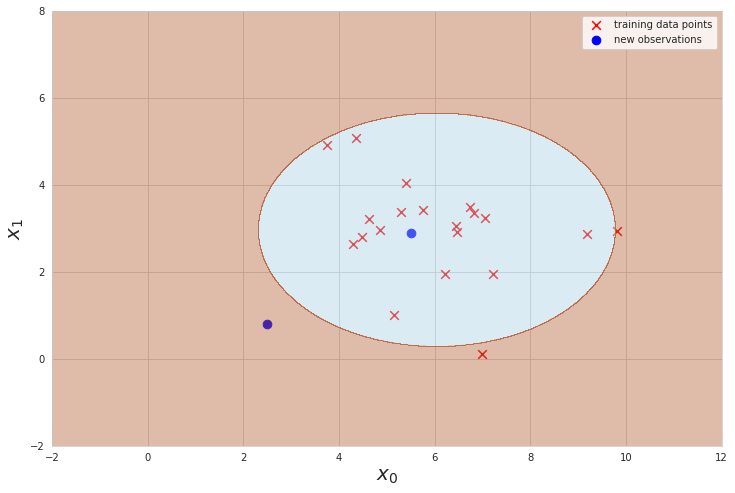

In [17]:
# display our randomly generated set of 20 data points in
# our 2 dimensional feature space
#plt.plot(x[:,0], x[:,1], 'rx', markersize=10, markeredgewidth=3, label='training data points')
plt.scatter(x[:,0], x[:,1], c='r', marker='x', s=75, label='training data points')
plt.xlabel('$x_0$', fontsize=20)
plt.ylabel('$x_1$', fontsize=20)
plt.axis([-2, 12, -2, 8])

# display location of 2 new observations we will use to demonstrate
# calculating the density or probability estimate
x_new = np.array([[5.5, 2.9],
                  [2.5, 0.8]])
#plt.plot(x_new[:,0], x_new[:,1], 'bo', markersize=10, markeredgewidth=3, label='new observations')
plt.scatter(x_new[:,0], x_new[:,1], c='b', marker='o', s=75, label='new observations')
plt.legend()


# and create a mesh to detect decision boundary for a given epsilon and plot it
epsilon = 0.005
x_min, x_max = -2.0, 12.0
y_min, y_max = -2.0, 8.0
h = .01  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

gridpoints = np.c_[xx.ravel(), yy.ravel()]
p = scipy.stats.norm.pdf(gridpoints, loc=mu_estimate, scale=sigma_estimate)
p = (np.prod(p, axis=1) < epsilon) * 1.0
Z = p.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.4);


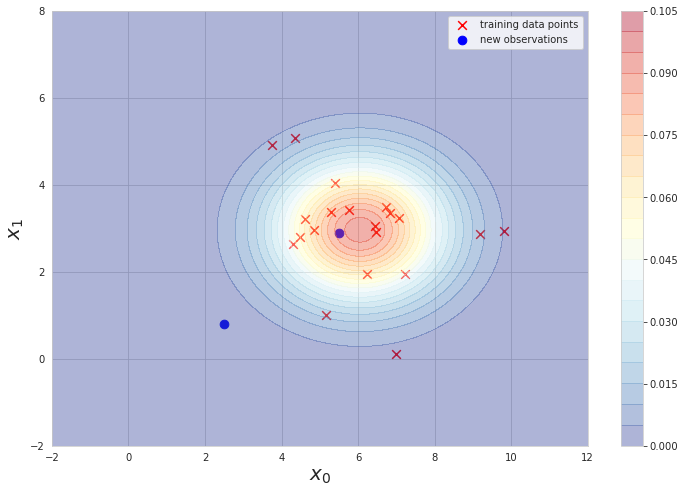

In [18]:
# display our randomly generated set of 20 data points in
# our 2 dimensional feature space
#plt.plot(x[:,0], x[:,1], 'rx', markersize=10, markeredgewidth=3, label='training data points')
plt.scatter(x[:,0], x[:,1], c='r', marker='x', s=75, label='training data points')
plt.xlabel('$x_0$', fontsize=20)
plt.ylabel('$x_1$', fontsize=20)
plt.axis([-2, 12, -2, 8])

# display location of 2 new observations we will use to demonstrate
# calculating the density or probability estimate
x_new = np.array([[5.5, 2.9],
                  [2.5, 0.8]])
#plt.plot(x_new[:,0], x_new[:,1], 'bo', markersize=10, markeredgewidth=3, label='new observations')
plt.scatter(x_new[:,0], x_new[:,1], c='b', marker='o', s=75, label='new observations')
plt.legend()


# and create a mesh to detect decision boundary for a given epsilon and plot it
epsilon = 0.005
x_min, x_max = -2.0, 12.0
y_min, y_max = -2.0, 8.0
h = .01  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

gridpoints = np.c_[xx.ravel(), yy.ravel()]
p = scipy.stats.norm.pdf(gridpoints, loc=mu_estimate, scale=sigma_estimate)
p = np.prod(p, axis=1)
Z = p.reshape(xx.shape)
levels = np.arange(0.0, 0.11, 0.005)
plt.contourf(xx, yy, Z, levels, cmap=plt.cm.RdYlBu_r, alpha=0.4);
plt.colorbar();


# Video W9 04: Developing and Evaluating an Anomaly Detection System

[YouTube Video Link](https://www.youtube.com/watch?v=20dfmwVwK-8&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=92)

To evaluate an anomaly detection system, we might get some labeled data.  Often this training set is
a bit skewed, we will often have a large colleciton of nonanomalous normal examples, with relatively few
anomalous examples.


## Training Example

Say we have data with 10000 good (normal) examples, and 20 flawed (anomalous) examples.

- Training set: use 6000 good examples ($y = 0$)
- CV: 2000 good examples ($y = 0$), 10 anomalous ($y = 1$)
- Test: 2000 good examples ($y = 0$), 10 anomalous ($y = 1$)

## Algorithm Evaluation

- Fit model $p(x)$ on training set $\{x^{(1)}, \cdots, x^{(m)}  \}$
- On cross validation/test example $x$, predict

\begin{equation}
y = 
\begin{cases}
0 & p(x) < \epsilon \text{anomaly}\\
1 & p(x) \ge \epsilon \text{normal}
\end{cases}
\end{equation}

Because the data is very skewed, classification accuracy would not be a very good metric to use
to evaluate your anomaly detector.  By predicting all items are not anomalous, you will get
pretty good accuracy if there are very few anomalous items.

Possible evaluation metrics:
- True postivie, false positive, false negative, true negative
- Precision/Recall
- $F_1$ -score

Can also use cross validation set to choose parameter $\epsilon$.

Lets give an example of how to compute these metrics.  First of all, we will make up some
data again with 2 features.  I will generate anomalies by randomly choosing some values that are
below a threshold, and removing them from the data set.

In [19]:
# same method as before, but generate 10020 points so we can pull out 20 anomalous points.
np.random.seed(42) # set seed so example is reproducable
m, n = 10020, 2 # number of example data points ; number of features/dimensions
mu_actual = np.array([5.0, 3.0])
sigma_actual = np.array([2.0, 1.0])

# we will generate a mxn array of values with mean 0 and std 1.0
x = np.random.normal(loc=0.0, scale=1.0, size=(m, n))

# and we will scale each dimension to have the desired mean/std.
x[:,0] = (x[:,0] * sigma_actual[0]) + mu_actual[0]
x[:,1] = (x[:,1] * sigma_actual[1]) + mu_actual[1]

In [20]:
# need to calculate the density estimate, so we can choose some values at random to be the anomalies
# get parameter estimates
mu_estimate = np.mean(x, axis=0)
sigma_estimate = np.std(x, axis=0)
print(mu_estimate, sigma_estimate)

# compute density estimate
p = scipy.stats.norm.pdf(x, loc=mu_estimate, scale=sigma_estimate)
p = np.prod(p, axis=1)
print(p.min(), p.max())

# determine the value for the 50 lowest scores, so we can randomly choose 20 of these 50 as anomalies
p_sorted = np.copy(p)
p_sorted.sort()
candidate_cutoff = p_sorted[50]
print(candidate_cutoff)
print(np.sum(p < candidate_cutoff))

# find indexes of the 50 candidates in original data
candidate_indexes = np.where(p < candidate_cutoff)[0]
print(candidate_indexes)

# randomly choose 20 of the candidate indexes to be anomalies
anomaly_indexes = np.random.choice(candidate_indexes, 20)
print(anomaly_indexes)

# extract these items for anomalies, and remove them from the training set x
x_anomalies = np.copy(x[anomaly_indexes])
print(x_anomalies.shape)

# bug? not sure why we end up with 10001 here, but none of the items
# removed appear to be in x so?
x = np.delete(x, anomaly_indexes, axis=0)
x = x[:10000,:]
print(x.shape)


[5.00686592 3.00814818] [2.02279433 0.99329815]
2.53267379519127e-06 0.07920067447773657
0.0003677434885608923
50
[ 104  131  580  978 1152 1447 1727 1858 1991 2319 2389 2425 2435 2688
 3445 3720 3805 3838 4082 4100 4124 4885 5367 5383 5544 5590 5669 5713
 5821 6122 6354 6456 6612 6722 6973 7290 7327 7581 7921 8690 8718 8873
 9059 9107 9407 9425 9515 9745 9837 9926]
[4885 5383 2319  131 5713 8718 7327 3805 1447 9059 1152 7921 1727 6456
  978 4124 8873 6456 3838 6612]
(20, 2)
(10000, 2)


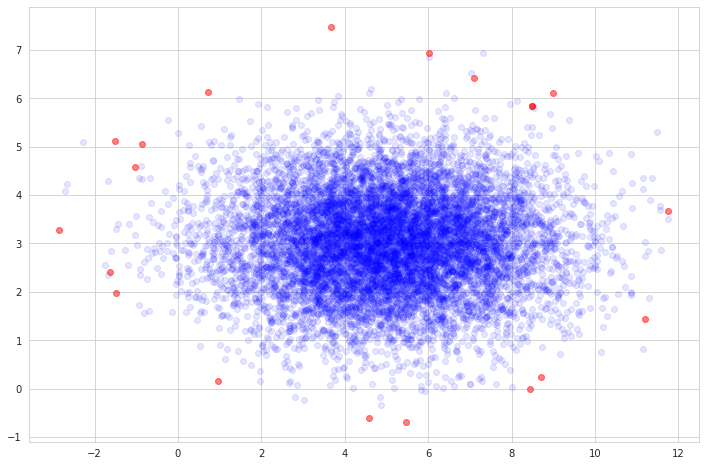

In [21]:
# visualize the points and anomalies
plt.plot(x[:,0], x[:,1], 'bo', alpha=0.1);
plt.plot(x_anomalies[:,0], x_anomalies[:,1], 'ro', alpha=0.5);

In [22]:
# we will split into train, cv and test sets as shown in the video
x_train = x[:6000, :]
x_cv = x[6000:8000, :]
x_test = x[8000:, :]
print(x_train.shape, x_cv.shape, x_test.shape)

x_anomalies_cv = x_anomalies[:10, :]
x_anomalies_test = x_anomalies[10:, :]
print(x_anomalies_cv.shape, x_anomalies_test.shape)

(6000, 2) (2000, 2) (2000, 2)
(10, 2) (10, 2)


In [23]:
# put the anomalies into the cv and test, and create a y labels for each
x_cv = np.concatenate((x_cv, x_anomalies_cv), axis=0)
x_test = np.concatenate((x_test, x_anomalies_test), axis=0)
print(x_cv.shape, x_test.shape)

# create y values, to make it easier to calculate evaluation metrics
# anomalies are "positive" or 1 cases, and normal are "negative" or 0 cases 
m, n = x_cv.shape
y_cv = np.zeros(m)
y_cv[2000:] = 1

m, n = x_test.shape
y_test = np.zeros(m)
y_test[2000:] = 1


(2010, 2) (2010, 2)


In [24]:
# retrain the density estimation only on the "normal" 6000 training items
p = scipy.stats.norm.pdf(x_train, loc=mu_estimate, scale=sigma_estimate)
p = np.prod(p, axis=1)
print(p.min(), p.max())

2.730093667765102e-05 0.07919897520096435


All of the previous was just to create a random data set with 10000 normal items and 20 anomalies.
We have also created our density estimates using a 6000 test subset of the data.

### True/False Positive/Negative rates

[reference](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)

Lets first look at calculating true/false positives and negatives as an evaluation method.  Lets try
to evalute using the method and the cross validation test set to try and set the optimal value
for epsilon $\epsilon$, which is our threshold for the anomaly detector.

The true vs. false and positive vs. negative is basically like a confusion matrix, but for a binary 
classifier there are only 2 output classes.  So for problems like this dataset, we expect to get a lot
of true negatives (because we consider normal or no anomaly as negative examples with $y = 0$) here.
So our interest is in the true positives we get, and the number of false negatives and positives.

In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
def compute_tfpn_metrics(y_true, y_pred):
    """Compute True/False Positive/Negative rates
    This could be vectorized, but lets be explicit to make sure we understand
    what we are calculating.
    """
    m = y_true.shape[0]
    tp = 0 # true positives
    tn = 0 # true negatives
    fp = 0 # false positives
    fn = 0 # false negatives
    for i in range(m):
        # a true positive is when y is positive and we predict positive
        if y_true[i] == 1 and y_pred[i] == 1:
            tp += 1
        
        # a true negative is when y is negative and we predict negative
        if y_true[i] == 0 and y_pred[i] == 0:
            tn += 1

        # a false positive is when y is negative but we predict positive
        if y_true[i] == 0 and y_pred[i] == 1:
            fp += 1

        # a false negative is when y is positive but we predict negative
        if y_true[i] == 1 and y_pred[i] == 0:
            fn += 1
        
    #print("True Positives : %5d   False Positives: %5d" % (tp, fp))
    #print("False Negatives: %5d   True Negatives:  %5d" % (fn, tn))
    return tp, fp, fn, tn

In [27]:
def plot_tfpn_matrix(y_true, y_pred):
    """Visualize the true/false positive/negatives confusion matrix.
    Here we use an actual confusin_matrix() function from sklearn.metrics
    But to display in the standard way, we have to completely flip
    the matrix around to get into the normal way one displays a the tfpn
    confusion matrix.
    """
    c = confusion_matrix(y_true, y_predicted)
    c = np.fliplr(c)
    c = np.flipud(c)
    c = c.T
    sns.heatmap(c, annot=True, cbar=False, fmt='0.0f', cmap=plt.cm.Blues, annot_kws={"size": 16}, linewidths=4);
    plt.xlabel('True Label', fontsize=16)
    plt.ylabel('Predicted Label', fontsize=16)
    plt.xticks([0.5, 1.5], labels=['Positive', 'Negative'])
    plt.yticks([0.5, 1.5], labels=['Positive', 'Negative'])
    plt.text(0.3, 0.4, 'True Positive (TP)', fontsize=16);
    plt.text(1.3, 0.4, 'False Positive (FP)', fontsize=16);
    plt.text(0.3, 1.4, 'False Negative (FN)', fontsize=16);
    plt.text(1.3, 1.4, 'True Negative (TN)', color='white', fontsize=16);

In [28]:
# we compute probability on the cv data using the mu_estimate and sigma_estimate
# from the training set calculated
# previously
p = scipy.stats.norm.pdf(x_cv, loc=mu_estimate, scale=sigma_estimate)
p = np.prod(p, axis=1)
print(p.min(), p.max())

# as an example, choose an epsilon and calculate the true/false positive/negatives
epsilon = 1e-04
y_predicted = (p < epsilon) * 1.0 # multiplying by 1 turns the boolean results into 1 or 0

1.3566191452835629e-05 0.07920067447773657


True Positives :     4   False Positives:     1
False Negatives:     6   True Negatives:   1999


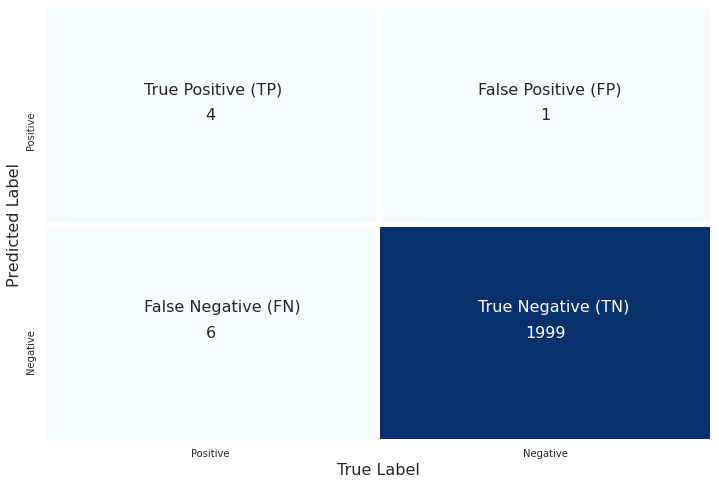

In [29]:
tp, fp, fn, tn = compute_tfpn_metrics(y_cv, y_predicted)
print("True Positives : %5d   False Positives: %5d" % (tp, fp))
print("False Negatives: %5d   True Negatives:  %5d" % (fn, tn))

plot_tfpn_matrix(y_cv, y_predicted)

As you can see, we ended up only getting 4 of the anomalies correct of the 10, and we
misclassified one of the normal items as an anomaly.  

Tuning this kind of threshold represents a tradeoff.  Is it worse to let 1 true anomaly get through
the system (false negatives here)?  Or are false positives to costly to deal with (e.g. because
we are annoying customers too much who aren't commiting fraud, or we are pulling too many
engines for inspection that are actually ok).

We can try a range of epsilon values, and see the FN/FP ratios that result.

In [30]:
# first try
for epsilon in np.logspace(-6, -1, 10):
    print('Testing epsilon %0.8f:' % epsilon)
    y_predicted = (p < epsilon) * 1.0 # multiplying by 1 turns the boolean results into 1 or 0
    tp, fp, fn, tn = compute_tfpn_metrics(y_cv, y_predicted)
    print("True Positives : %5d   False Positives: %5d" % (tp, fp))
    print("False Negatives: %5d   True Negatives:  %5d" % (fn, tn))
    print("\n")

Testing epsilon 0.00000100:
True Positives :     0   False Positives:     0
False Negatives:    10   True Negatives:   2000


Testing epsilon 0.00000359:
True Positives :     0   False Positives:     0
False Negatives:    10   True Negatives:   2000


Testing epsilon 0.00001292:
True Positives :     0   False Positives:     0
False Negatives:    10   True Negatives:   2000


Testing epsilon 0.00004642:
True Positives :     2   False Positives:     1
False Negatives:     8   True Negatives:   1999


Testing epsilon 0.00016681:
True Positives :     4   False Positives:     1
False Negatives:     6   True Negatives:   1999


Testing epsilon 0.00059948:
True Positives :    10   False Positives:    12
False Negatives:     0   True Negatives:   1988


Testing epsilon 0.00215443:
True Positives :    10   False Positives:    48
False Negatives:     0   True Negatives:   1952


Testing epsilon 0.00774264:
True Positives :    10   False Positives:   201
False Negatives:     0   True Negatives:  

In [31]:
# we really want something between 0.00004 and 0.00050
# second try
for epsilon in np.linspace(0.00004, 0.0005, 20):
    print('Testing epsilon %0.8f:' % epsilon)
    y_predicted = (p < epsilon) * 1.0 # multiplying by 1 turns the boolean results into 1 or 0
    tp, fp, fn, tn = compute_tfpn_metrics(y_cv, y_predicted)
    print("True Positives : %5d   False Positives: %5d" % (tp, fp))
    print("False Negatives: %5d   True Negatives:  %5d" % (fn, tn))
    print("\n")

Testing epsilon 0.00004000:
True Positives :     1   False Positives:     1
False Negatives:     9   True Negatives:   1999


Testing epsilon 0.00006421:
True Positives :     3   False Positives:     1
False Negatives:     7   True Negatives:   1999


Testing epsilon 0.00008842:
True Positives :     4   False Positives:     1
False Negatives:     6   True Negatives:   1999


Testing epsilon 0.00011263:
True Positives :     4   False Positives:     1
False Negatives:     6   True Negatives:   1999


Testing epsilon 0.00013684:
True Positives :     4   False Positives:     1
False Negatives:     6   True Negatives:   1999


Testing epsilon 0.00016105:
True Positives :     4   False Positives:     1
False Negatives:     6   True Negatives:   1999


Testing epsilon 0.00018526:
True Positives :     6   False Positives:     1
False Negatives:     4   True Negatives:   1999


Testing epsilon 0.00020947:
True Positives :     7   False Positives:     1
False Negatives:     3   True Negatives:  

So we perhaps want something like $\epsilon = 0.00028211$ where we only caught almost all of
the anomalies while only have 3 false positives.  Lets see how that setting of epsilon works
for the held back final test set.

In [32]:
# calculate density on the test set now
p = scipy.stats.norm.pdf(x_test, loc=mu_estimate, scale=sigma_estimate)
p = np.prod(p, axis=1)
print(p.min(), p.max())

# and check the fn/fp ratio
epsilon = 0.00028211
y_predicted = (p < epsilon) * 1.0 # multiplying by 1 turns the boolean results into 1 or 0
tp, fp, fn, tn = compute_tfpn_metrics(y_cv, y_predicted)
print("True Positives : %5d   False Positives: %5d" % (tp, fp))
print("False Negatives: %5d   True Negatives:  %5d" % (fn, tn))

2.53267379519127e-06 0.07916662594378182
True Positives :     7   False Positives:     7
False Negatives:     3   True Negatives:   1993


### Precision and Recall

[reference](https://towardsdatascience.com/precision-vs-recall-386cf9f89488)

Calculating precision and recall is just taking the true/false positive/negatives and calculating
some actual ratios.  We can calculate Precision, Recall and Accuracy

\begin{equation}
\text{Precision} = \frac{\text{True Positive (TP)}}{\text{Actual Results}} = \frac{\text{True Positive (TP)}}{\text{True Positive (TP) + False Positive (FP)}}
\end{equation}

\begin{equation}
\text{Recall} = \frac{\text{True Positive (TP)}}{\text{Predicted Results}} = \frac{\text{True Positive (TP)}}{\text{True Positive (TP) + False Negative (FN)}}
\end{equation}

\begin{equation}
\text{Accuracy} = \frac{\text{True Positive (TP)} + \text{True Negative (TN)}}{\text{Total}} 
\end{equation}

Often, we think that precision and recall both indicate accuracy of the model. While that is somewhat true, there is a deeper, distinct meaning of each of these terms. Precision means the percentage of your results which are relevant. On the other hand, recall refers to the percentage of total relevant results correctly classified by your algorithm.

Lets redo the last epsilon meta search, but calculate precision and recall scores instead.

In [33]:
def compute_precision_recall(y_true, y_predicted):
    tp, fp, fn, tn = compute_tfpn_metrics(y_true, y_predicted)
    precision = float(tp) / float(tp + fp)
    recall = float(tp) / float(tp + fn)
    m = y_true.shape[0]
    accuracy = float(tp + tn) / float(m)
    return precision, recall, accuracy

In [34]:
# compute density on cv set
p = scipy.stats.norm.pdf(x_cv, loc=mu_estimate, scale=sigma_estimate)
p = np.prod(p, axis=1)
print(p.min(), p.max())

# we really want something between 0.00004 and 0.00050
# second try
for epsilon in np.linspace(0.00004, 0.0005, 20):
    print('Testing epsilon %0.8f:' % epsilon)
    y_predicted = (p < epsilon) * 1.0 # multiplying by 1 turns the boolean results into 1 or 0
    precision, recall, accuracy = compute_precision_recall(y_cv, y_predicted)
    print('precision: %0.5f, recall: %0.5f, accuracy: %0.5f' % (precision, recall, accuracy))
    print("\n")

1.3566191452835629e-05 0.07920067447773657
Testing epsilon 0.00004000:
precision: 0.50000, recall: 0.10000, accuracy: 0.99502


Testing epsilon 0.00006421:
precision: 0.75000, recall: 0.30000, accuracy: 0.99602


Testing epsilon 0.00008842:
precision: 0.80000, recall: 0.40000, accuracy: 0.99652


Testing epsilon 0.00011263:
precision: 0.80000, recall: 0.40000, accuracy: 0.99652


Testing epsilon 0.00013684:
precision: 0.80000, recall: 0.40000, accuracy: 0.99652


Testing epsilon 0.00016105:
precision: 0.80000, recall: 0.40000, accuracy: 0.99652


Testing epsilon 0.00018526:
precision: 0.85714, recall: 0.60000, accuracy: 0.99751


Testing epsilon 0.00020947:
precision: 0.87500, recall: 0.70000, accuracy: 0.99801


Testing epsilon 0.00023368:
precision: 0.77778, recall: 0.70000, accuracy: 0.99751


Testing epsilon 0.00025789:
precision: 0.77778, recall: 0.70000, accuracy: 0.99751


Testing epsilon 0.00028211:
precision: 0.75000, recall: 0.90000, accuracy: 0.99801


Testing epsilon 0.0003

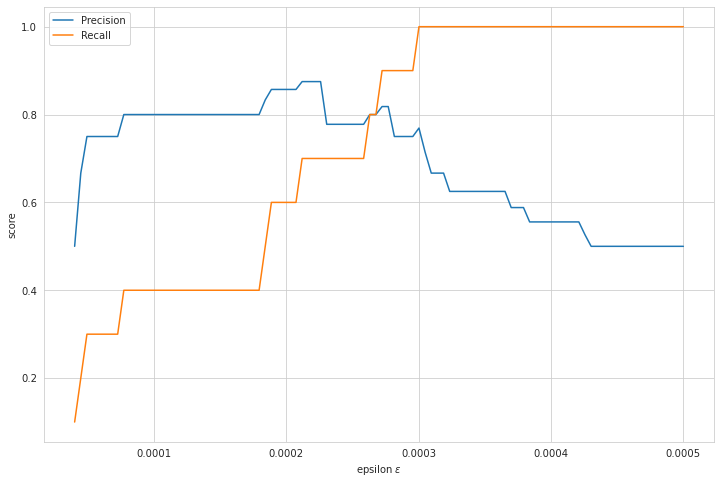

In [35]:
# it can also be useful to plot recall and precision as functions of the parameter (epsilon).
# basically the location they cross represents the most balanced trade off you can achieve

# we really want something between 0.00004 and 0.00050
# second try
NUM_TESTS = 100
epsilons = np.linspace(0.00004, 0.0005, NUM_TESTS)
precision = np.empty(NUM_TESTS)
recall = np.empty(NUM_TESTS)
accuracy = np.empty(NUM_TESTS)
for i, epsilon in enumerate(epsilons):
    y_predicted = (p < epsilon) * 1.0 # multiplying by 1 turns the boolean results into 1 or 0
    precision[i], recall[i], accuracy[i] = compute_precision_recall(y_cv, y_predicted)

plt.plot(epsilons, precision, label='Precision')
plt.plot(epsilons, recall, label='Recall')
plt.xlabel('epsilon $\epsilon$')
plt.ylabel('score')
plt.legend();

### $F_1$ score

In most problems you could either give a higher priority to maximizing precision, or recall, depending
on the problem.  The $F_1$ score is a simpler metric which takes both into account.  The $F_1$ score
is simply the harmonic mean of precision and recall:

\begin{equation}
F_1 = 2 \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
\end{equation}

In [36]:
def compute_f1_score(y_true, y_predicted):
    precision, recall, accuracy = compute_precision_recall(y_true, y_predicted)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

In [37]:
# compute density on cv set
p = scipy.stats.norm.pdf(x_cv, loc=mu_estimate, scale=sigma_estimate)
p = np.prod(p, axis=1)
print(p.min(), p.max())

# we really want something between 0.00004 and 0.00050
# second try
for epsilon in np.linspace(0.00004, 0.0005, 20):
    print('Testing epsilon %0.8f:' % epsilon)
    y_predicted = (p < epsilon) * 1.0 # multiplying by 1 turns the boolean results into 1 or 0
    f1 = compute_f1_score(y_cv, y_predicted)
    print('f1: %0.5f' % (f1))
    print("\n")

1.3566191452835629e-05 0.07920067447773657
Testing epsilon 0.00004000:
f1: 0.16667


Testing epsilon 0.00006421:
f1: 0.42857


Testing epsilon 0.00008842:
f1: 0.53333


Testing epsilon 0.00011263:
f1: 0.53333


Testing epsilon 0.00013684:
f1: 0.53333


Testing epsilon 0.00016105:
f1: 0.53333


Testing epsilon 0.00018526:
f1: 0.70588


Testing epsilon 0.00020947:
f1: 0.77778


Testing epsilon 0.00023368:
f1: 0.73684


Testing epsilon 0.00025789:
f1: 0.73684


Testing epsilon 0.00028211:
f1: 0.81818


Testing epsilon 0.00030632:
f1: 0.80000


Testing epsilon 0.00033053:
f1: 0.76923


Testing epsilon 0.00035474:
f1: 0.76923


Testing epsilon 0.00037895:
f1: 0.74074


Testing epsilon 0.00040316:
f1: 0.71429


Testing epsilon 0.00042737:
f1: 0.66667


Testing epsilon 0.00045158:
f1: 0.66667


Testing epsilon 0.00047579:
f1: 0.66667


Testing epsilon 0.00050000:
f1: 0.66667




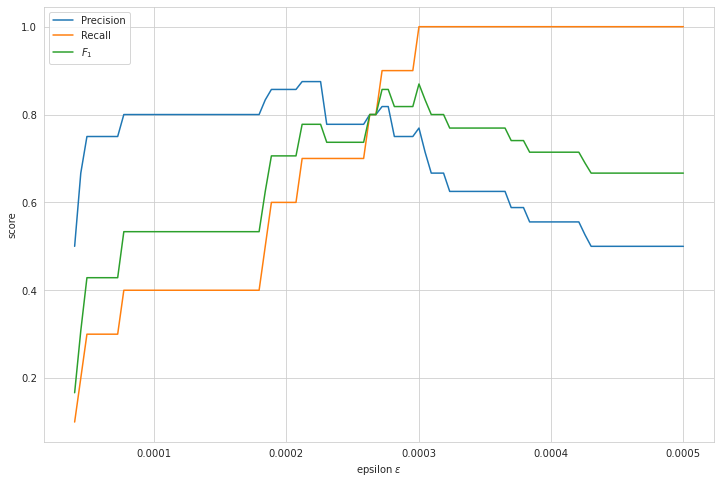

In [38]:
# it can also be useful to plot recall and precision as functions of the parameter (epsilon).
# basically the location they cross represents the most balanced trade off you can achieve

# we really want something between 0.00004 and 0.00050
# second try
NUM_TESTS = 100
epsilons = np.linspace(0.00004, 0.0005, NUM_TESTS)
precision = np.empty(NUM_TESTS)
recall = np.empty(NUM_TESTS)
accuracy = np.empty(NUM_TESTS)
f1 = np.empty(NUM_TESTS)
for i, epsilon in enumerate(epsilons):
    y_predicted = (p < epsilon) * 1.0 # multiplying by 1 turns the boolean results into 1 or 0
    precision[i], recall[i], accuracy[i] = compute_precision_recall(y_cv, y_predicted)
    f1[i] = compute_f1_score(y_cv, y_predicted)
    
plt.plot(epsilons, precision, label='Precision')
plt.plot(epsilons, recall, label='Recall')
plt.plot(epsilons, f1, label='$F_1$')
plt.xlabel('epsilon $\epsilon$')
plt.ylabel('score')
plt.legend();

# Video W9 05: Anomaly Detection vs. Supervised Learning

[YouTube Video Link](https://www.youtube.com/watch?v=mGXtKNHLRMg&index=93&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW)


Why don't we just use a supervised learning algorithm instead of the anomaly detection if we have
some examples of anomalous values.

**Anomaly Detection**

- very small number of positive examples ($y = 1$).  0-20 is common
- Large number of negative ($y = 0$) examples.
- Many different "types" of anomalies.  Hard for any algorithm to learn from positive examples what the
  anomalies look like; future anomalies may look nothing like any of the anomalous examples we've seen
  so far.

**Supervised Learning**

- Normally have a reasonalbly large number of positive and negative examples.
- Enough positive examples for algorithm to get a sense of what positive examples are like, future
  positive examples likely to be similar to ones in training set.
  
Key difference is usually in anomaly detection we have such a small number of positive examples that it
is not possible for a supervised learning method to learn that much from the positive examples.

# Video W9 06: Choosing what Features to Use

[YouTube Video Link](https://www.youtube.com/watch?v=YrCQ0uRcNCk&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=94)

- Non-gaussian features may be problematic, can we transform it to be more "gaussian" looking
  - $\log(x)$ transform
  - or $\log(x + 1)$ or $\log(x + c)$
  - $\sqrt{x}$ or $\sqrt[4]{x}$

# Video W9 07: Multivariate Gaussian Distribution

[YouTube Video Link](https://www.youtube.com/watch?v=fr5wML3y1Xk&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=95)


# Video W9 08: Anomaly Detection using Multivariate Gaussian Distribution

[YouTube Video Link](https://www.youtube.com/watch?v=EobKYbaJAHM&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=96)


In [40]:
import sys
sys.path.append("../../src") # add our class modules to the system PYTHON_PATH

from ml_python_class.custom_funcs import version_information
version_information()

              Module   Versions
--------------------   ------------------------------------------------------------
         matplotlib:   ['3.3.0']
              numpy:   ['1.18.5']
             pandas:   ['1.0.5']
              scipy:   ['1.5.1']
            seaborn:   ['0.10.1']
